# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [ ]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.1/378.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.2 MB/s eta 0:00:00


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [ ]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

In [5]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

In [4]:

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [6]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [7]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-05-19 12:59:00--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.003s  

2025-05-19 12:59:00 (7.03 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-05-19 12:59:01--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [8]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  print(movie_docs)
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = (datetime.now() - timedelta(days=4-i)).strftime("%B %d, %Y at %I:%M %p")

  documents.extend(movie_docs)

[Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': '8'}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity."), Document(metadata={'source': 'john_wick_1.csv', 'row': 1, 'Review_Date': '17 January 2015', 'Review_Title': ' Story: 3 minutes; Enterta

In [6]:
len(documents)

100

Let's look at an example document to see if everything worked as expected!

In [12]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': 'May 15, 2025 at 02:08 PM'}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [9]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [10]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [12]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model ="gpt-4.1-nano")


### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [13]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [77]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. Many reviews are very positive, praising its stylish action, choreography, and overall entertainment value, with some giving ratings of 8, 9, or even 10 out of 10. However, there are a few mixed or negative opinions as well, with some reviewers giving lower ratings like 2, 5, or 6, and expressing confusion or less enthusiasm for the film. Overall, the common sentiment is that the film was well-received and appreciated by a majority of viewers.'

In [78]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [79]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick series, the main storyline centers around John Wick, a retired hitman who seeks vengeance after a series of personal tragedies. In the first film, he comes out of retirement to hunt down gangsters who killed his dog and stole his car, uncovering a dangerous criminal underworld along the way. The sequels explore his continued involvement in this world, including helping an old friend take over the Assassin's Guild, dealing with old enemies, and confronting new threats, all while navigating a strict code of rules and intense action sequences. The series emphasizes themes of revenge, loyalty, and the consequences of one’s actions—all conveyed through stylized, high-octane combat scenes."

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [37]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [38]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [82]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people's opinions on John Wick vary. Some reviewers highly praise the first film, calling it stylish, exciting, and a must-see for action fans, indicating that many people did like it. However, other reviews, especially for the later films, express negative opinions, describing the third movie as dull and overly violent, and the fourth as weak and lacking plot, suggesting that not everyone liked the series as it progressed. Overall, it seems that many viewers generally liked John Wick, particularly the first installment, but opinions on the later movies are more mixed."

In [83]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Based on the provided reviews, none of the reviews have a rating of 10.'

In [84]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick series, the storyline revolves around John Wick, a former hitman seeking vengeance and redemption. The movies depict intense and stylized action sequences, with Wick facing numerous assassins and criminal organizations. Throughout the series, Wick navigates a dangerous underworld filled with elaborate rules, rivalries, and deadly confrontations. The films are known for their choreographed action, emotional depth, and a complex universe of assassin societies.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [15]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [16]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [87]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. The first two reviews are highly positive, with ratings of 9 and 10 out of 10, praising the film's action sequences, style, and Keanu Reeves' performance. The third review, however, is more mixed, giving a rating of 5 out of 10 and expressing some disappointment, but overall, the majority of the reviews indicate that people liked the movie."

In [88]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [89]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, John Wick is a retired hitman who returns to his violent past after a series of events. In the first film, he comes out of retirement to avenge the death of his dog and the theft of his car, leading to a relentless quest for vengeance against those who wronged him. The second film involves him being drawn back into the criminal underworld when a former colleague asks for his help, which results in a series of violent confrontations and a bounty on his head. Overall, the story revolves around Wick's skills as an assassin, his struggles with the criminal organizations, and his desire for peace amidst deadly chaos."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [17]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [18]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [92]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. Several reviews are very positive, highlighting the film\'s exciting action sequences, stylish visuals, and overall entertainment value. For example, reviews with ratings of 9 and 8 praise the movies as "sheer enjoyment" and "slick, violent fun," and mention that the franchise has set new standards for action films. Although some reviews are more mixed or negative, the overall sentiment leans toward enjoyment and appreciation of the series\' action and style.'

In [93]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. The URLs to those reviews are:\n\n1. /review/rw4854296/?ref_=tt_urv\n2. /review/rw9033669/?ref_=tt_urv'

In [94]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick film series, the story revolves around a retired hitman named John Wick, played by Keanu Reeves, who seeks revenge after a series of personal tragedies. In the first film, he comes out of retirement after gangsters kill his dog and steal his car, leading him on a violent and relentless vendetta against those who wronged him. The series continues to explore his involvement in the criminal underworld, where he faces increasingly dangerous enemies, including Russian mobsters and professional killers, all while navigating a highly secretive assassin society with strict rules. The films are known for their stylish action sequences, choreography, and the protagonist's quest for vengeance and peace."

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [19]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [20]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/tmp/ipykernel_892067/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [21]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [22]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [23]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [103]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the provided reviews, people's opinions on John Wick vary. Some reviewers express strong positive feelings, calling the series highly recommended and well choreographed. However, at least one reviewer gave a very negative review, criticizing the latest movie in the series and expressing dislike for it. Overall, many seem to like the series, but opinions on the fourth film are mixed."

In [104]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [105]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick film series, John Wick is a retired assassin who is drawn back into the criminal underworld. In the first movie, he seeks revenge after gangsters kill his dog and steal his car, unleashing a violent rampage against those who wronged him. The second installment continues his adventures, with Wick pulled back in when he is forced to help an Italian crime boss and gets entangled in a series of violent confrontations across different locations. Overall, the series depicts John Wick's journey of vengeance, action-packed battles, and his struggle to find peace while dealing with the deadly consequences of his past."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [24]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [25]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [108]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. Many reviews are highly positive, praising the film\'s action sequences, style, and Keanu Reeves\' performance. For example, one review gave it a 10/10, describing it as "something special," and others rated it 9 or 8, highlighting its fluid action, stylish world-building, and entertainment value. While there are some negative opinions, such as ratings of 1 or 2, the overall sentiment leans toward appreciation and enjoyment of the film.'

In [109]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. [Review URL](https://example.com/review/rw4854296/?ref_=tt_urv) — Review titled "A Masterpiece & Brilliant Sequel" for John Wick 3\n2. [Review URL](https://example.com/review/rw8991670/?ref_=tt_urv) — Review titled "I Don\'t Get It" for John Wick 1\n3. [Review URL](https://example.com/review/rw9033669/?ref_=tt_urv) — Review titled "You don\'t mess with another person\'s dog. It\'s as simple as that!" for John Wick 1\n\n(Note: The actual URLs are as provided in the data: /review/rw4854296/?ref_=tt_urv, /review/rw8991670/?ref_=tt_urv, and /review/rw9033669/?ref_=tt_urv. If you need clickable links, you can prepend the base website domain as needed.)'

In [110]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick film series, the storyline centers around John Wick, an ex-hitman who seeks revenge after a series of tragic events. The first movie reveals that Wick's beloved dog is killed and his car is stolen by gangsters, prompting him to come out of retirement to hunt down those responsible. Over the series, Wick confronts various criminal organizations, navigates the rules of a secret assassin society, and faces escalating challenges from enemies and professional killers, all while trying to find peace. The films are known for their stylized action sequences, world-building within the criminal underworld, and themes of vengeance and consequence."

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [ ]:
#!pip install -qU langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [26]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [26]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [27]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [28]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [29]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [ ]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems that people generally liked John Wick. The action sequences, Keanu Reeves' performance, and the unique style of the film were highly praised by reviewers."

In [ ]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is one review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [ ]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is an ultra-violent movie series that follows the story of an ex-hitman seeking revenge after gangsters killed his dog and took everything from him. The first installment features John Wick coming out of retirement to track down those responsible. The series is known for its elaborate action sequences, vivid choreography, and intense violence.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [ ]:
### YOUR CODE HERE

In [27]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/spdhnes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/spdhnes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

In [28]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [29]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.3),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.2),
]

In [31]:
from ragas.testset import TestsetGenerator


generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node a2d74b9c-a0f3-4c7e-abfa-da5658ea1e09 does not have a summary. Skipping filtering.
Node 16daa444-b80b-4c14-8156-21a3a1dad32b does not have a summary. Skipping filtering.
Node 5a070a7b-40a8-4d36-8008-3338958ad8c1 does not have a summary. Skipping filtering.
Node 8985a3b8-7d9a-4bf9-8350-25733ba6d6f5 does not have a summary. Skipping filtering.
Node d27a87ca-d10f-4e2a-90cc-a1f8c1580a3f does not have a summary. Skipping filtering.
Node fa8a9192-b6e1-4519-aceb-793952fe7268 does not have a summary. Skipping filtering.
Node d635a6ce-666f-4184-8e6a-1134d7209bcb does not have a summary. Skipping filtering.
Node 9c611f1d-3ca8-407c-ac26-1791eb1f0626 does not have a summary. Skipping filtering.
Node cbeb8008-8e2b-4253-b927-7220ee037cd3 does not have a summary. Skipping filtering.
Node be7fd487-0cb4-4a67-8328-18dea1209c67 does not have a summary. Skipping filtering.
Node d85ec360-a327-4c20-a30d-2ed940068e8d does not have a summary. Skipping filtering.
Node c54769a4-8ccb-4d0d-a0af-487042dc0dfa d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/223 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [32]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How is John Wick described in terms of its plo...,[: 0\nReview: The best way I can describe John...,John Wick is described as a movie with a simpl...,single_hop_specifc_query_synthesizer
1,"Why did the reviewer decide to check out ""John...",[: 2\nReview: With the fourth installment scor...,"The reviewer decided to check out ""John Wick"" ...",single_hop_specifc_query_synthesizer
2,Why John wick so good?,[: 3\nReview: John wick has a very simple reve...,John wick has a simple revenge story where Kea...,single_hop_specifc_query_synthesizer
3,Wha is Reevs in action movies?,[: 4\nReview: Though he no longer has a taste ...,"Savvy, indestructible Reeves looks right at ho...",single_hop_specifc_query_synthesizer
4,How does the narrative critique of the expandi...,[<1-hop>\n\n: 7\nReview: John Wick (2014) is t...,The narrative critique highlights that the exp...,multi_hop_abstract_query_synthesizer
5,How do the action scenes in Parabellum reflect...,[<1-hop>\n\n: 6\nReview: Assassin John Wick is...,The action scenes in Parabellum highlight John...,multi_hop_abstract_query_synthesizer
6,How does the revenge and retribution theme rel...,[<1-hop>\n\n: 19\nReview: If you've seen the f...,The revenge and retribution theme is central t...,multi_hop_abstract_query_synthesizer
7,Considering the high emotional intensity of Jo...,[<1-hop>\n\n: 11\nReview: JOHN WICK is a rare ...,The review highlights that while John Wick is ...,multi_hop_abstract_query_synthesizer
8,How does the character Wick exemplify the high...,[<1-hop>\n\n: 18\nReview: When the story begin...,The context describes Wick as a super-assassin...,multi_hop_specific_query_synthesizer
9,How does the film 'John Wick' reflect the infl...,"[<1-hop>\n\n: 1\nReview: The Table, the intern...",The film 'John Wick' showcases elaborate actio...,multi_hop_specific_query_synthesizer


### 1. Naive RAG Chain

In [ ]:
res=naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})#["response"].content
res

In [31]:
res['context'][-1].page_content

': 3\nReview: John wick has a very simple revenge story. It can be summarized as "Keanu gets angry and shoots bad guys" but what makes it special? Directed by Chad Stahelski who\'s a stunt specialist boy does it show because the main selling point in the film are some real virtuoso action sequences, well made choreographies. Unlike today\'s action movies, it doesn\'t use quick-cuts or shaky cameras actually see what\'s going on.'

In [33]:
'\n'.join([doc.page_content for doc in res['context']])

': 5\nReview: Ultra-violent first entry with lots of killings, thrills , noisy action , suspense , and crossfire . In this original John Wick (2014) , an ex-hit-man comes out of retirement to track down the gangsters that killed his dog and took everything from him . With the untimely death of his beloved wife still bitter in his mouth he seeks for vengeance . But when an arrogant Russian mob prince and hoodlums steal his car and kill his dog , they are fully aware of his lethal capacity. The Bogeyman will find himself dragged into an impossible task as every killer in the business dreams of cornering the legendary Wick who now has an enormous price on his head . In this first installment John Wick , blind with revenge, and for his salvation John will immediately unleash a carefully orchestrated maelstrom of destruction against those attempt to chase him and with a price tag on his head, as he is the target of hit men : an army of bounty-hunting killers on his trail and a murderer woma

### Response Generation by Retrivers

In [ ]:
import pandas as pd
my_retrivers_dict={key: '' for key in ['naive_retrieval_chain','bm25_retrieval_chain', 'contextual_compression_retrieval_chain', 'MultiQueryRetriever', 'parent_document_retrieval_chain', 'ensemble_retrieval_chain']}

[*my_retrivers_dict]

In [ ]:
import time
my_retrivers_list=[naive_retrieval_chain,bm25_retrieval_chain, contextual_compression_retrieval_chain, multi_query_retrieval_chain, parent_document_retrieval_chain, ensemble_retrieval_chain]

for names, retrivals in zip([*my_retrivers_dict], my_retrivers_list):
    for test_row in dataset:
        inputs = test_row.eval_sample.user_input
        res = retrivals.invoke({"question": inputs})           
        test_row.eval_sample.response = res["response"].content
        context = [doc.page_content for doc in res['context']]   
        test_row.eval_sample.retrieved_contexts = context
    my_retrivers_dict[names]=dataset
    time.sleep(6)

In [126]:
my_retrivers_dict['naive_retrieval_chain'].to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,So like John Wick is just like Taken but with ...,[: 0\nReview: The best way I can describe John...,[: 0\nReview: The best way I can describe John...,John Wick is so good for action movie fans lik...,John Wick is a beautifully simple action movie...,single_hop_specifc_query_synthesizer
1,Considering the popularity and the high-octane...,"[: 9\nReview: At first glance, John Wick sound...",[: 2\nReview: With the fourth installment scor...,"The ""John Wick"" franchise is particularly appe...","The context indicates that ""John Wick"" is a hi...",single_hop_specifc_query_synthesizer
2,Who is Chad Stahelski and what is his signific...,[: 17\nReview: Stuntman turned writer/director...,[: 3\nReview: John wick has a very simple reve...,Chad Stahelski is a former stuntman who turned...,"Chad Stahelski is the director of John Wick, a...",single_hop_specifc_query_synthesizer
3,Is the actor Reeves known for his action roles...,[: 7\nReview: John Wick (2014) is the best rev...,[: 4\nReview: Though he no longer has a taste ...,"Yes, Keanu Reeves, the actor Reeves, is known ...","Yes, Reeves is described as savvy and indestru...",single_hop_specifc_query_synthesizer
4,How does set design and lightning-fast reflexe...,[: 16\nReview: John Wick Chapter 2 pits Keanu ...,[<1-hop>\n\n: 16\nReview: John Wick Chapter 2 ...,Set design and lightning-fast reflexes both pl...,"In John Wick Chapter 2, the set design is high...",multi_hop_abstract_query_synthesizer
5,How does Keanu Reeves' portrayal of the legend...,[: 8\nReview: In this 2nd installment of John ...,[<1-hop>\n\n: 5\nReview: Ultra-violent first e...,Keanu Reeves' portrayal of the legendary assas...,"The context describes John Wick as a dark, sty...",multi_hop_abstract_query_synthesizer
6,"How does the revenge plot in John Wick, driven...",[: 3\nReview: John wick has a very simple reve...,"[<1-hop>\n\n: 9\nReview: At first glance, John...","The revenge plot in John Wick, driven by the m...",The revenge plot in John Wick is initiated by ...,multi_hop_abstract_query_synthesizer
7,How do the cinematic style and choreography co...,"[: 9\nReview: At first glance, John Wick sound...","[<1-hop>\n\n: 9\nReview: At first glance, John...",The cinematic style and choreography in John W...,The review highlights that John Wick is 'brisk...,multi_hop_abstract_query_synthesizer
8,Considering the high-octane action sequences a...,[: 20\nReview: In a world where movie sequels ...,[<1-hop>\n\n: 12\nReview: If there's an equiva...,The 'John Wick' series maintains its consisten...,The series maintains its consistency through i...,multi_hop_specific_query_synthesizer
9,John Wick Chapter 2 is like super long and ful...,[: 23\nReview: I love me a bit of the old ultr...,"[<1-hop>\n\n: 9\nReview: ""John Wick: Chapter 2...","Yes, John Wick Chapter 2 is highly suitable fo...","Based on the context, John Wick Chapter 2 is a...",multi_hop_specific_query_synthesizer


In [131]:
my_retrivers_dict['bm25_retrieval_chain'].to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,So like John Wick is just like Taken but with ...,[: 0\nReview: The best way I can describe John...,[: 0\nReview: The best way I can describe John...,John Wick is especially popular among action m...,John Wick is a beautifully simple action movie...,single_hop_specifc_query_synthesizer
1,Considering the popularity and the high-octane...,"[: 9\nReview: At first glance, John Wick sound...",[: 2\nReview: With the fourth installment scor...,"The ""John Wick"" franchise is particularly appe...","The context indicates that ""John Wick"" is a hi...",single_hop_specifc_query_synthesizer
2,Who is Chad Stahelski and what is his signific...,[: 17\nReview: Stuntman turned writer/director...,[: 3\nReview: John wick has a very simple reve...,Chad Stahelski is a stunt specialist turned fi...,"Chad Stahelski is the director of John Wick, a...",single_hop_specifc_query_synthesizer
3,Is the actor Reeves known for his action roles...,[: 7\nReview: John Wick (2014) is the best rev...,[: 4\nReview: Though he no longer has a taste ...,"Yes, Keanu Reeves is well known for his action...","Yes, Reeves is described as savvy and indestru...",single_hop_specifc_query_synthesizer
4,How does set design and lightning-fast reflexe...,[: 16\nReview: John Wick Chapter 2 pits Keanu ...,[<1-hop>\n\n: 16\nReview: John Wick Chapter 2 ...,Set design and lightning-fast reflexes both co...,"In John Wick Chapter 2, the set design is high...",multi_hop_abstract_query_synthesizer
5,How does Keanu Reeves' portrayal of the legend...,[: 8\nReview: In this 2nd installment of John ...,[<1-hop>\n\n: 5\nReview: Ultra-violent first e...,Keanu Reeves' portrayal of the legendary assas...,"The context describes John Wick as a dark, sty...",multi_hop_abstract_query_synthesizer
6,"How does the revenge plot in John Wick, driven...",[: 3\nReview: John wick has a very simple reve...,"[<1-hop>\n\n: 9\nReview: At first glance, John...","The revenge plot in *John Wick*, driven by the...",The revenge plot in John Wick is initiated by ...,multi_hop_abstract_query_synthesizer
7,How do the cinematic style and choreography co...,"[: 9\nReview: At first glance, John Wick sound...","[<1-hop>\n\n: 9\nReview: At first glance, John...",The cinematic style and choreography in John W...,The review highlights that John Wick is 'brisk...,multi_hop_abstract_query_synthesizer
8,Considering the high-octane action sequences a...,[: 20\nReview: In a world where movie sequels ...,[<1-hop>\n\n: 12\nReview: If there's an equiva...,The 'John Wick' series maintains its consisten...,The series maintains its consistency through i...,multi_hop_specific_query_synthesizer
9,John Wick Chapter 2 is like super long and ful...,[: 23\nReview: I love me a bit of the old ultr...,"[<1-hop>\n\n: 9\nReview: ""John Wick: Chapter 2...","Yes, John Wick Chapter 2 is suitable for actio...","Based on the context, John Wick Chapter 2 is a...",multi_hop_specific_query_synthesizer


In [ ]:
my_retrivers_dict

### RAGAS Evaluation Setup

In [37]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [38]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

In [150]:
my_ragas_result_dict={keys:'' for keys in [*my_retrivers_dict]}

In [151]:
from ragas import EvaluationDataset
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy#, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

for keys in [*my_ragas_result_dict]:
    evaluation_dataset = EvaluationDataset.from_pandas(my_retrivers_dict[keys].to_pandas())
    result = evaluate(
        dataset=evaluation_dataset,
        metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy()],
        llm=evaluator_llm,
        run_config=custom_run_config
    )
    my_ragas_result_dict[keys]=result

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

In [152]:
my_ragas_result_dict

{'naive_retrieval_chain': {'context_recall': 0.9792, 'faithfulness': 0.9269, 'factual_correctness(mode=f1)': 0.4850, 'answer_relevancy': 0.9469},
 'bm25_retrieval_chain': {'context_recall': 1.0000, 'faithfulness': 0.9499, 'factual_correctness(mode=f1)': 0.5000, 'answer_relevancy': 0.9482},
 'contextual_compression_retrieval_chain': {'context_recall': 1.0000, 'faithfulness': 0.9400, 'factual_correctness(mode=f1)': 0.5017, 'answer_relevancy': 0.9490},
 'MultiQueryRetriever': {'context_recall': 1.0000, 'faithfulness': 0.9557, 'factual_correctness(mode=f1)': 0.5133, 'answer_relevancy': 0.9473},
 'parent_document_retrieval_chain': {'context_recall': 0.9722, 'faithfulness': 0.9431, 'factual_correctness(mode=f1)': 0.4858, 'answer_relevancy': 0.9467},
 'ensemble_retrieval_chain': {'context_recall': 1.0000, 'faithfulness': 0.9723, 'factual_correctness(mode=f1)': 0.4967, 'answer_relevancy': 0.9476}}

In [2]:
cp /mnt/c/Users/spdhn/OneDrive/Desktop/AIM06/ragas_results.png .


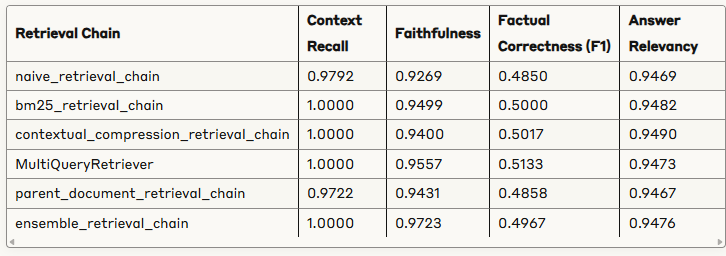

In [5]:

from IPython.display import display, Image

display(Image('ragas_results.png'))


contextual_recall: naive_retrival_chain

## LangSmith DataSet

In [41]:
from langsmith import Client

client = Client()

dataset_name = "Jonh Wick Movies - Reviews"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Reviews of John Wick's Movies."
)

In [42]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

In [43]:
eval_llm = ChatOpenAI(model="gpt-4.1")

In [44]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

# Add prepare_data to the qa_evaluator
qa_evaluator = LangChainStringEvaluator(
    "qa", 
    config={"llm": eval_llm},
    prepare_data=lambda run, example: {
        "prediction": run.outputs["response"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

# This one already looks good
labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm": eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["response"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

# Add prepare_data to the dope_or_nope_evaluator as well
dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm": eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["response"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

### LangSmith Evaluator

In [48]:
result=evaluate(
    naive_retrieval_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)
my_retrivers_dict_langsmith['naive_retrieval_chain']=result

View the evaluation results for experiment: 'worthwhile-plough-13' at:
https://smith.langchain.com/o/9d6a760c-505a-4b81-8b76-580952ac0db8/datasets/dfc6ef64-5f41-48df-8e64-d86333376224/compare?selectedSessions=70143186-b908-44af-842f-4a207065ecf6




0it [00:00, ?it/s]

/home/spdhnes/AIE6/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/langchain/evaluation/schema.py:130: UserWarning: Ignoring reference in CriteriaEvalChain, as it is not expected.
To use references, use the labeled_criteria instead.
  warn(self._skip_reference_warning)
/home/spdhnes/AIE6/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/langchain/evaluation/schema.py:130: UserWarning: Ignoring reference in CriteriaEvalChain, as it is not expected.
To use references, use the labeled_criteria instead.
  warn(self._skip_reference_warning)
/home/spdhnes/AIE6/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/langchain/evaluation/schema.py:130: UserWarning: Ignoring reference in CriteriaEvalChain, as it is not expected.
To use references, use the labeled_criteria instead.
  warn(self._skip_reference_warning)
/home/spdhnes/AIE6/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/langchain/evaluation/schema.py:130: UserWarning: Ignoring reference in CriteriaEvalChai

In [46]:
import pandas as pd
my_retrivers_dict_langsmith={key: '' for key in ['naive_retrieval_chain','bm25_retrieval_chain', 'contextual_compression_retrieval_chain', 'multi_query_retrieval_chain', 'parent_document_retrieval_chain', 'ensemble_retrieval_chain']}

[*my_retrivers_dict_langsmith]

['naive_retrieval_chain',
 'bm25_retrieval_chain',
 'contextual_compression_retrieval_chain',
 'multi_query_retrieval_chain',
 'parent_document_retrieval_chain',
 'ensemble_retrieval_chain']

In [ ]:
import time

my_retrivers_list_=[bm25_retrieval_chain, contextual_compression_retrieval_chain, multi_query_retrieval_chain, parent_document_retrieval_chain, ensemble_retrieval_chain]

# for names in [*my_retrivers_dict_langsmith]:
for names, retrivals in zip([*my_retrivers_dict_langsmith], my_retrivers_list_):
    result= evaluate(
            retrivals.invoke,
            data=dataset_name,
            evaluators=[
                qa_evaluator,
                labeled_helpfulness_evaluator,
                dope_or_nope_evaluator
            ],
            metadata={"revision_id": "default_chain_init"},
            )
    my_retrivers_dict_langsmith[names]=result
    time.sleep(60)

In [50]:
# cp /mnt/c/Users/spdhn/OneDrive/Desktop/AIM06/langsmith_performance_1.png .
# cp /mnt/c/Users/spdhn/OneDrive/Desktop/AIM06/langsmith_performance_2.png .
# cp /mnt/c/Users/spdhn/OneDrive/Desktop/AIM06/langsmith_performance_3.png .


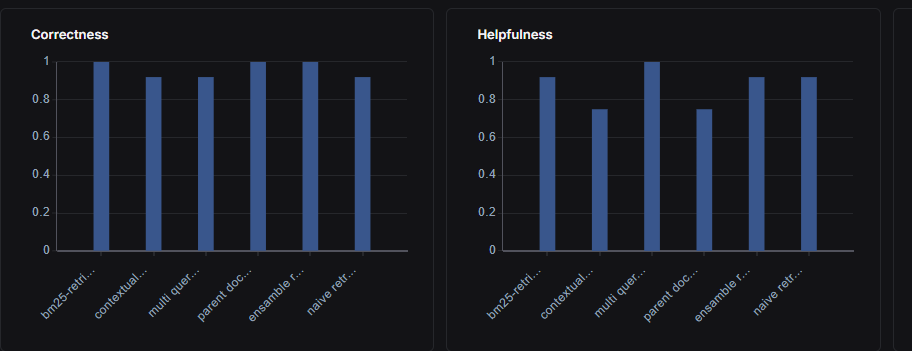

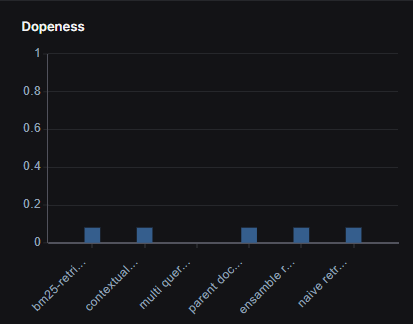

: 

In [63]:
from IPython.display import display, Image
import matplotlib.pyplot as plt

display(Image('langsmith_performance_1.png')),display(Image('langsmith_performance_4.png'))
plt.show()

1. Multi-Query does not capture the dopeness of the reviews, but it proves to be the most effective retriever overall. 
2. BM25, Parent Document, and Ensemble retrievers perform at a similarly high level of accuracy.


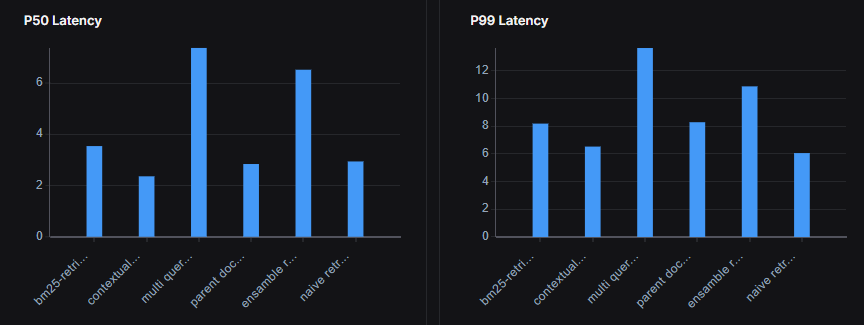

In [53]:
display(Image('langsmith_performance_2.png'))

🔸 P50 Latency (50th percentile / median latency): (Gives a good sense of typical performance):

Contextual retriever has the best typical performance because 50% (or more) requests completed faster than or equal to 2 sec.


🔸 P99 Latency (99th percentile): (Only the slowest 1% of requests took longer than this):

naive rag retriever shows the best P99 Latency, meaning that 99% of all requestes completed faster than or equal to 6 sec.

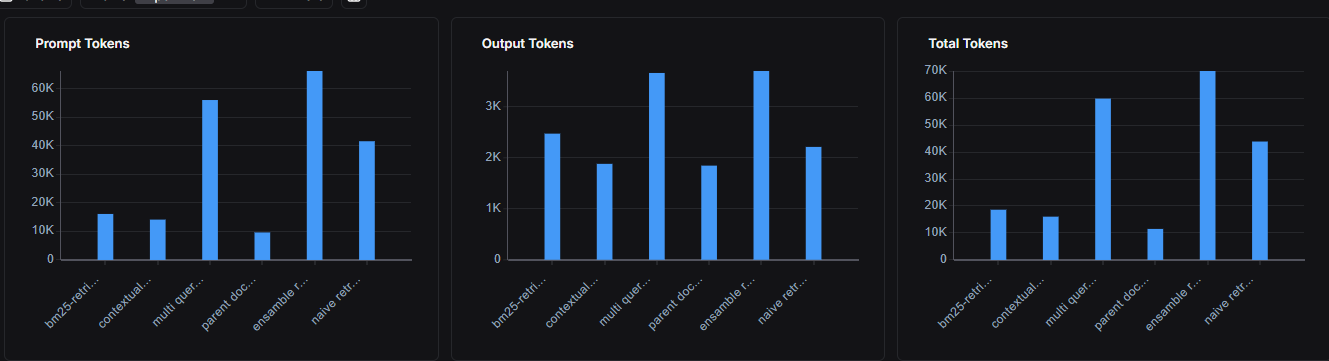

In [56]:
display(Image('langsmith_performance_3.png'))

The Parent Document retriever uses the fewest total tokens, resulting in lower overall cost.